# Libraries 

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from numpy.random import 
from sklearn.metrics import r2_score
from os import listdir


In [23]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    966 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          71 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,966.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,728.039384,57.375856,69.876812,10529.335616,6.100171,5.575342,1971.960616,1985.496575,104.122203,449.238014,...,98.566781,47.887842,20.954623,4.118151,13.825342,2.449486,48.681507,6.313356,2007.815068,181232.391267
std,425.167321,43.522414,25.134547,10734.611698,1.392623,1.119803,30.113498,20.460717,180.019763,464.193569,...,127.081601,67.992642,59.988335,32.372083,52.857153,37.828606,548.727100,2.695216,1.336347,80018.113192
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,355.500000,20.000000,59.000000,7500.000000,5.000000,5.000000,1954.000000,1968.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,722.500000,50.000000,69.000000,9525.000000,6.000000,5.000000,1974.000000,1994.500000,0.000000,385.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162700.000000
75%,1105.250000,70.000000,80.000000,11608.500000,7.000000,6.000000,2001.000000,2004.000000,167.750000,719.250000,...,171.250000,69.250000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213625.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [24]:
train["LogSalePrice"] = train.SalePrice.apply(np.log)


In [25]:
combined = train.drop(["SalePrice", "LogSalePrice"], axis=1).append(test)
nan_percentage = combined.isnull().sum().sort_values(ascending=False) / combined.shape[0]
missing_val = nan_percentage[nan_percentage > 0]

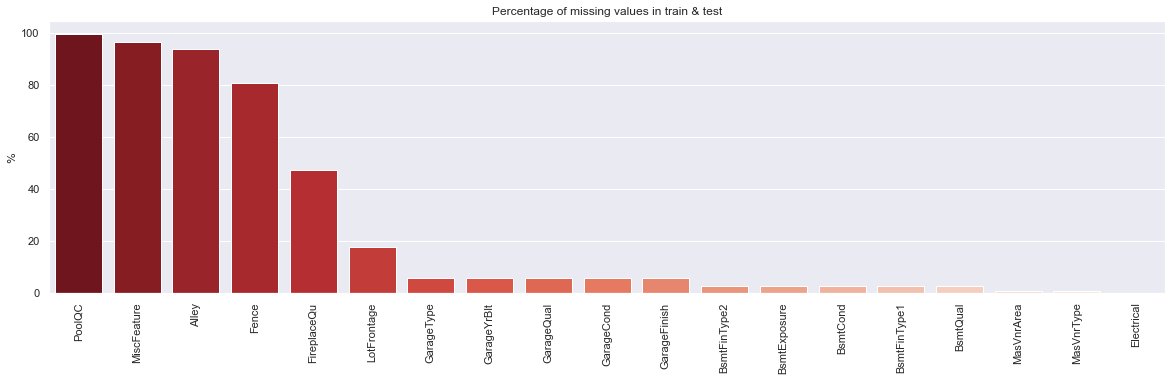

In [8]:
plt.figure(figsize=(20,5))
sns.barplot(x=missing_val.index.values, y=missing_val.values * 100, palette="Reds_r");
plt.title("Percentage of missing values in train & test");
plt.ylabel("%");
plt.xticks(rotation=90);

# Finding categorical features in numerical candidates 

In [26]:
num_candidates = list(combined.dtypes[combined.dtypes!="object"].index.values)
num_candidates

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


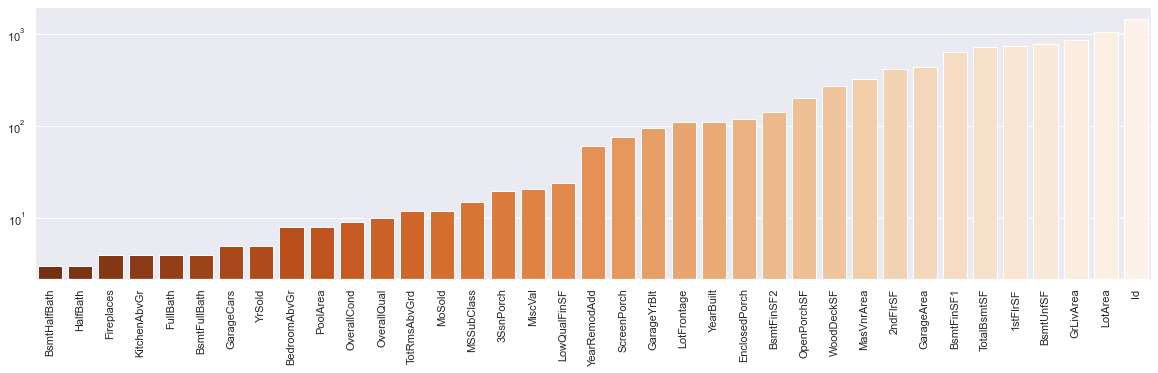

In [12]:
unique_counts = combined.loc[:, num_candidates].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90);
plt.yscale("log")

In [27]:
cat_candidates = list(combined.dtypes[combined.dtypes=="object"].index.values)

num_to_cats = ["BsmtHalfBath", "HalfBath", "KitchenAbvGr", "BsmtFullBath", "Fireplaces", "FullBath", "GarageCars",
               "BedroomAbvGr", "OverallCond", "OverallQual", "TotRmsAbvGrd", "MSSubClass", "YrSold", "MoSold", 
               "GarageYrBlt", "YearRemodAdd"]

for feat in num_to_cats:
    num_candidates.remove(feat)
    cat_candidates.append(feat)
    combined[feat] = combined[feat].astype("object")
    train[feat] = train[feat].astype("object")
    test[feat] = test[feat].astype("object")

In [14]:
len(num_candidates)

21

In [15]:
len(cat_candidates)

58

# Insights

In [28]:
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition'], dtype=object)

C:\Users\DELL\AppData\Local\Temp/ipykernel_11832/2369362153.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float), palette="Blues_r")


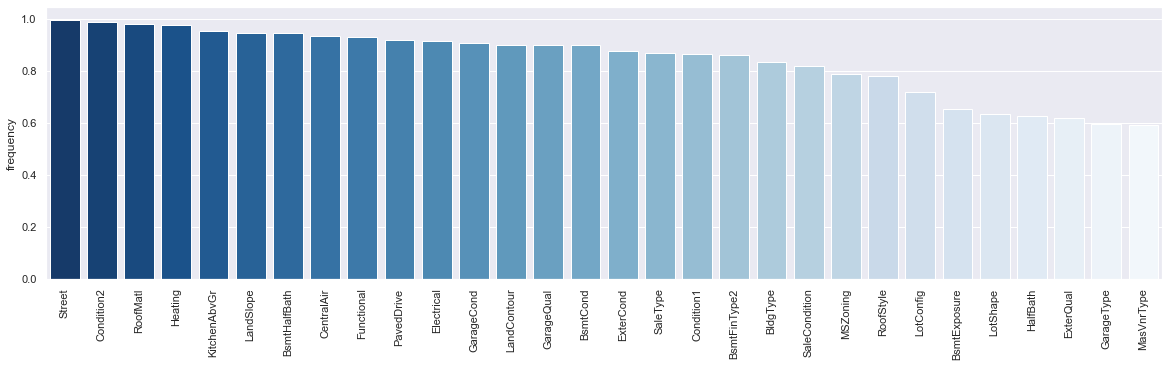

In [17]:
"""
Many categorical candidates have one major level that occupies > 80 % of the data. That's bad.
"""

frequencies = []
for col in cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float), palette="Blues_r")
plt.xticks(rotation=90);

In [29]:
cats_to_drop = ["Utilities"]

"""
Removing Utilities from train , test , cat_candidates 
"""

combined = combined.drop(cats_to_drop, axis=1)
train = train.drop(cats_to_drop, axis=1)
test = test.drop(cats_to_drop, axis=1)

In [30]:


cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates


array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition'], dtype=object)

In [142]:
# def build_map(useless_levels, plugin_level, train_levels):
#     plugin_map = {}
#     for level in useless_levels:
#         plugin_map[level] = plugin_level
#     for level in train_levels:
#         plugin_map[level] = level
#     return plugin_map

In [143]:
# def clean_test_levels(train, test):
#     for col in test.columns:
#         train_levels = set(train[col].unique())
#         test_levels = set(test[col].unique())
#         in_test_not_in_train = test_levels.difference(train_levels)
#         if len(in_test_not_in_train)>0:
#             close_to_mean_level = train.groupby(col).LogSalePrice.mean() - train.SalePrice.apply(np.log).mean()
#             close_to_mean_level = close_to_mean_level.apply(np.abs)
#             plugin_level = close_to_mean_level.sort_values().index.values[0]
#             in_test_not_in_train = list(in_test_not_in_train)
#             plugin_map = build_map(in_test_not_in_train, plugin_level, train_levels)
#             test[col] = test[col].map(plugin_map)
#     return train, test

In [144]:
#train, test = clean_test_levels(train, test)


In [31]:
test["MSSubClass"].value_counts()


20     97
60     67
50     32
120    17
30     16
70     15
90     14
80      8
160     7
75      5
85      5
45      3
190     3
180     2
40      1
Name: MSSubClass, dtype: int64

# Outliers 

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

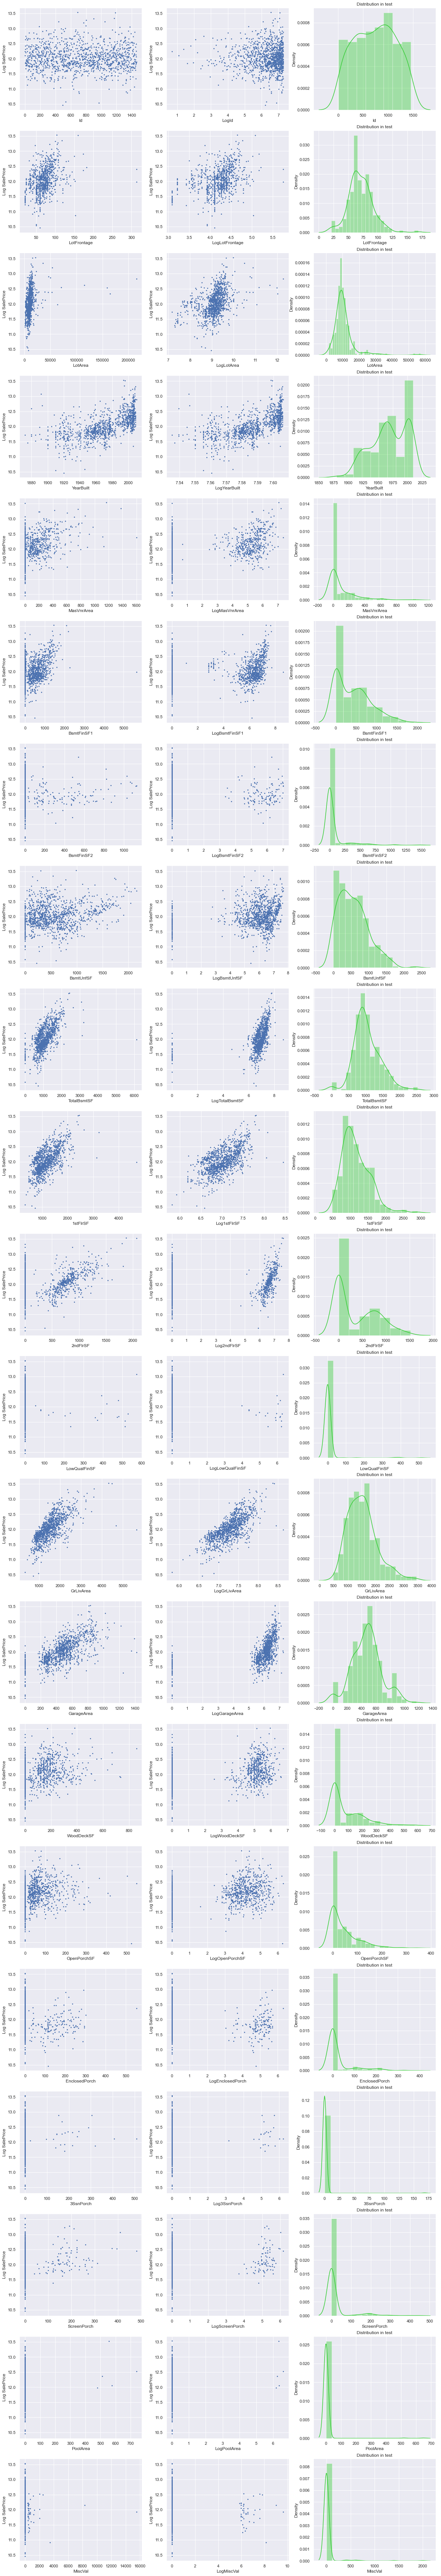

In [32]:
fig, ax = plt.subplots(len(num_candidates),3,figsize=(20,len(num_candidates)*6))

for n in range(len(num_candidates)):
    feat = num_candidates[n]
    ax[n,0].scatter(train[feat].values, np.log(train.SalePrice.values), s=4)
    ax[n,0].set_ylabel("Log SalePrice")
    ax[n,0].set_xlabel(feat);
    ax[n,1].scatter(np.log(train[feat].values+1), np.log(train.SalePrice.values), s=4)
    ax[n,1].set_ylabel("Log SalePrice")
    ax[n,1].set_xlabel("Log" + feat);
    sns.distplot(test[feat].dropna(), kde=True, ax=ax[n,2], color="limegreen")
    ax[n,2].set_title("Distribution in test")

In [34]:
outlier_ids = set()
outlier_ids = outlier_ids.union(set(train[train.LotArea > 60000].index.values))
outlier_ids = outlier_ids.union(set(train[train.LotFrontage > 200].index.values))
outlier_ids = outlier_ids.union(set(train[(train.LotFrontage > 150) & (train.SalePrice.apply(np.log) < 11)].index.values))
outlier_ids = outlier_ids.union(set(train[train.GrLivArea > 4500].index.values))
outlier_ids = outlier_ids.union(set(train[train["1stFlrSF"] > 4000].index.values))
outlier_ids = outlier_ids.union(set(train[train.MasVnrArea > 1400].index.values))
outlier_ids = outlier_ids.union(set(train[train["BsmtFinSF1"] > 5000].index.values))
outlier_ids = outlier_ids.union(set(train[train.TotalBsmtSF > 6000].index.values))
outlier_ids = outlier_ids.union(set(train[(train.OpenPorchSF > 500) & (np.log(train.SalePrice) < 11)].index.values))

In [35]:
outlier_ids

{113, 131, 228, 250, 393, 443, 444, 503, 554, 700, 1037}

In [36]:
train.shape


(1168, 81)

In [37]:
train = train.drop(list(outlier_ids))
combined = combined.drop(list(outlier_ids))

In [38]:
train.shape

(1157, 81)

# Imputing missing values

In [39]:
def impute_na_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("None")
        df[col] = df[col].astype("object")
    else:
        df[col] = df[col].fillna(df[col].mod)
    return df



In [40]:
for col in combined.columns:
    combined = impute_na_trees(combined, col)
    
for col in train.columns:
    train = impute_na_trees(train, col)
    
for col in test.columns:
    test = impute_na_trees(test, col  )    

In [41]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
len(num_candidates)

19

# Generating obvious new features 

In [42]:
combined["TotalSF"] = combined["1stFlrSF"] + combined["2ndFlrSF"] + combined["TotalBsmtSF"] 
combined["GreenArea"] = combined["LotArea"] - combined["GrLivArea"] - combined["GarageArea"]

In [43]:
cat_col=train.select_dtypes(include="object").columns
for i in cat_col:
    train[i]=train[i].astype("category")

# Nominal Encoding

In [48]:


train[["ExterQual","ExterCond","BsmtQual"
       ,"BsmtCond","BsmtExposure", "BsmtFinType1" 
       ,'BsmtFinType2','HeatingQC','KitchenQual'
      , 'GarageFinish', 'GarageCond']]=train[["ExterQual","ExterCond","BsmtQual"
       ,"BsmtCond","BsmtExposure", "BsmtFinType1" 
       ,'BsmtFinType2','HeatingQC','KitchenQual'
      , 'GarageFinish', 'GarageCond']].astype('category')


test[["ExterQual","ExterCond","BsmtQual"
       ,"BsmtCond","BsmtExposure", "BsmtFinType1" 
       ,'BsmtFinType2','HeatingQC','KitchenQual'
      , 'GarageFinish', 'GarageCond']]=test[["ExterQual","ExterCond","BsmtQual"
       ,"BsmtCond","BsmtExposure", "BsmtFinType1" 
       ,'BsmtFinType2','HeatingQC','KitchenQual'
      , 'GarageFinish', 'GarageCond']].astype('category')


Cat_Label_columns=train.select_dtypes('category').columns.to_list()
for i in Cat_Label_columns :
    train[i]=train[i].cat.codes
    test[i]=test[i].cat.codes
    
train_object_col=train.select_dtypes('object').columns.to_list()
test_object_col=test.select_dtypes('object').columns.to_list()

Train_Final_DF=pd.get_dummies(train, columns=train_object_col)
Test_Final_DF=pd.get_dummies(test, columns=test_object_col)
Target=Train_Final_DF.SalePrice
final_train, final_test = Train_Final_DF.align(Test_Final_DF, join='inner', axis=1)
print(f"{final_train.shape}\n{final_test.shape}")

In [ ]:
y=Target
final_train.drop(["SalePrice"], axis=1, inplace=True)
X=final_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Random Forest 

In [ ]:

"""
0.8962609884094713 submitted 
# """
rf = RandomForestRegressor(n_estimators = 600, max_depth = 100,random_state = 127)
rf.fit(X_train, y_train)

predict = rf.predict(X_test)
mean_squared_error(predict, y_test )
mean_squared_error(predict, y_test, squared = False)
r2_score(y_test, predict)
